# Modelling version-2:

In the first version, we tried creating a baseline model using a subset of pages. We developed a single model that captures the temporal relationships for each of the pages and is able to predict the number of visits. 

In this notebook, we will use prophet to create a model that is able to perform more accurately while handling a larger subset of pages. 

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from joblib import Parallel, delayed

## Load the data:

In [194]:
PATH= "../data/train_1.csv"

In [195]:
df= pd.read_csv(PATH)

In [196]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


What are the columns in the dataset?

In [198]:
df.columns

Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
       '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=551)

Other dataframes

In [199]:
PATH_2= "../data/key_1.csv"

In [200]:
key_df= pd.read_csv(PATH_2)

In [201]:
key_df.head()

,Page,Id
0,!vote_en.wikipedia.org_all-access_all-agents_2...,bf4edcf969af
1,!vote_en.wikipedia.org_all-access_all-agents_2...,929ed2bf52b9
2,!vote_en.wikipedia.org_all-access_all-agents_2...,ff29d0f51d5c
3,!vote_en.wikipedia.org_all-access_all-agents_2...,e98873359be6
4,!vote_en.wikipedia.org_all-access_all-agents_2...,fa012434263a


In [202]:
key_df.shape

(8703780, 2)

`key_df` contains the alpha-numeric ID for each Page and Date combination

In [203]:
# for example
key_df.iloc[1].Page

'!vote_en.wikipedia.org_all-access_all-agents_2017-01-02'

## Melt the dataframe:

First, drop rows with null values

In [204]:
df=df.dropna()

In [205]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0


Take a sample from the dataframe

In [206]:
df_sample=df.sample(n=500, random_state=42)

In [207]:
df_sample.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
42042,Luis_Suárez_en.wikipedia.org_all-access_all-ag...,4261.0,3872.0,3896.0,4270.0,3973.0,4300.0,4115.0,4028.0,3846.0,...,4437.0,3676.0,3226.0,3291.0,3836.0,4008.0,4092.0,3764.0,3719.0,3477.0
99800,"Фрейзер,_Джо_ru.wikipedia.org_all-access_all-a...",291.0,347.0,335.0,305.0,283.0,270.0,302.0,327.0,303.0,...,421.0,391.0,528.0,418.0,403.0,356.0,379.0,388.0,365.0,243.0
53520,Dr_House_fr.wikipedia.org_mobile-web_all-agents,304.0,264.0,417.0,230.0,1002.0,406.0,318.0,321.0,345.0,...,450.0,442.0,335.0,373.0,914.0,728.0,961.0,1648.0,501.0,500.0
80024,File:Penny_black.jpg_commons.wikimedia.org_mob...,0.0,1.0,5.0,0.0,0.0,1.0,0.0,2.0,0.0,...,1.0,0.0,2.0,1.0,1.0,3.0,1.0,2.0,1.0,1.0
106799,射鵰英雄傳_(2008年電視劇)_zh.wikipedia.org_mobile-web_a...,121.0,107.0,107.0,117.0,107.0,111.0,114.0,105.0,105.0,...,339.0,387.0,178.0,179.0,339.0,330.0,387.0,342.0,524.0,218.0


Now melt the dataframe

In [208]:
melted= df_sample.melt(id_vars='Page',var_name='Date' , value_name= 'Visits')

Let's check out the melted dataframe

In [209]:
melted.head(10)

,Page,Date,Visits
0,Luis_Suárez_en.wikipedia.org_all-access_all-ag...,2015-07-01,4261.0
1,"Фрейзер,_Джо_ru.wikipedia.org_all-access_all-a...",2015-07-01,291.0
2,Dr_House_fr.wikipedia.org_mobile-web_all-agents,2015-07-01,304.0
3,File:Penny_black.jpg_commons.wikimedia.org_mob...,2015-07-01,0.0
4,射鵰英雄傳_(2008年電視劇)_zh.wikipedia.org_mobile-web_a...,2015-07-01,121.0
5,Steyr_(Traktorenhersteller)_de.wikipedia.org_d...,2015-07-01,58.0
6,Category:Nude_in_photography_commons.wikimedia...,2015-07-01,98.0
7,張善為_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
8,Bahlika_en.wikipedia.org_all-access_all-agents,2015-07-01,11.0
9,Ronaldinho_es.wikipedia.org_desktop_all-agents,2015-07-01,2804.0


## Splitting the data:

Split the data into training and validation set

In [210]:
melted['DateTime'] = pd.to_datetime(melted['Date'])

In [211]:
melted.Date.min(), melted.Date.max()

('2015-07-01', '2016-12-31')

In [212]:
earliest_date=melted.DateTime.min()
melted['time_step'] = (melted['DateTime'] - earliest_date).dt.days

In [213]:
melted.tail()

,Page,Date,Visits,DateTime,time_step
274995,スタジオジブリ_ja.wikipedia.org_all-access_all-agents,2016-12-31,1125.0,2016-12-31,549
274996,Печенеги_ru.wikipedia.org_all-access_all-agents,2016-12-31,1509.0,2016-12-31,549
274997,Boy_George_en.wikipedia.org_mobile-web_all-agents,2016-12-31,5228.0,2016-12-31,549
274998,Decathlon_en.wikipedia.org_mobile-web_all-agents,2016-12-31,812.0,2016-12-31,549
274999,Saroo_Brierley_en.wikipedia.org_desktop_all-ag...,2016-12-31,2187.0,2016-12-31,549


Rename some columns before splitting

In [214]:
# Renaming columns inplace
melted.rename(columns={'DateTime': 'ds', 'Visits': 'y','Page':'page'}, inplace=True)

Use the last month data as validation data

In [215]:
train=melted[melted['time_step']<520].copy()
valid=melted[melted['time_step']>=520].copy()

In [216]:
train=train[['ds','y','page']]
valid=valid[['ds','y','page']]

## Training `Prophet` model:

In [217]:
# p=list()

# for page in train['page'].unique():
#     print(f'Page:{page}')
    
#     # get training and validation set
#     train_= train.loc[train['page']== page]
#     valid_= valid.loc[valid['page']== page]

#     # build model
#     m= Prophet(seasonality_mode='additive', yearly_seasonality=False, 
#                 weekly_seasonality=True, daily_seasonality=True)
    
#     # train the model
#     m.fit(train_)

#     # create future
#     future = m.make_future_dataframe(periods=valid_.shape[0], include_history=False)
#     forecast= m.predict(future)
#     forecast= m.predict(future)
#     forecast['page']=page
#     p.append(forecast[['ds', 'yhat', 'page']])



In [218]:
# p = pd.concat(p, ignore_index=True)
# p['yhat'] = p['yhat'].clip(lower=0)
# p = p.merge(valid, on=['ds', 'page'], how='left')

Calculate performance

In [219]:
def smape(actual, forecast):
    result = 1/len(actual) * np.sum(2*np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)
    return result

In [220]:
# smape(p['y'], p['yhat'])

In [221]:
valid.shape

(15000, 3)

Let's plot our predictions

In [222]:
# fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
# ax = ax.flatten()
# for ax_ ,family in enumerate(p['page'].unique()[:6]):
#     p_ = p.loc[p['page'] == family]
#     p_.plot(x='ds', y='y', ax=ax[ax_], label='Visits')
#     p_.plot(x='ds', y='yhat', ax=ax[ax_], label='Forecast')
#     ax[ax_].set_title(family)
#     ax[ax_].legend()
#     ax[ax_].set_xlabel('Date')
#     ax[ax_].set_ylabel('Sales')
# fig.tight_layout()
# plt.show()

## Parallelize `Prophet`

In [228]:
def run_one(train_, valid_, page):
    print(f'Page:{page}')  

    # build model
    m= Prophet(seasonality_mode='additive', yearly_seasonality=True, 
                weekly_seasonality=True, daily_seasonality=False)
    
    # train the model
    m.fit(train_)

    # create future
    future = m.make_future_dataframe(periods=valid_.shape[0], include_history=False)
    forecast= m.predict(future)
    forecast= m.predict(future)
    forecast['page']=page
    return forecast[['ds', 'yhat', 'page']]

Create a list of jobs

In [229]:
jobs = list()
for page in train['page'].unique():
    train_= train.loc[train['page']== page]
    valid_= valid.loc[valid['page']== page]
    jobs.append(delayed(run_one)(train_, valid_, page))

Run parallel jobs

In [230]:
p = Parallel(n_jobs=4)(jobs)
p = pd.concat(p, ignore_index=True)
p['yhat'] = p['yhat'].clip(lower=0)
p = p.merge(valid, on=['ds', 'page'], how='left')

Page:Luis_Suárez_en.wikipedia.org_all-access_all-agents
Page:Фрейзер,_Джо_ru.wikipedia.org_all-access_all-agents
Page:Dr_House_fr.wikipedia.org_mobile-web_all-agents
Page:File:Penny_black.jpg_commons.wikimedia.org_mobile-web_all-agents
Page:射鵰英雄傳_(2008年電視劇)_zh.wikipedia.org_mobile-web_all-agents
Page:Steyr_(Traktorenhersteller)_de.wikipedia.org_desktop_all-agents
Page:Category:Nude_in_photography_commons.wikimedia.org_desktop_all-agents
Page:張善為_zh.wikipedia.org_all-access_spider


00:14:34 - cmdstanpy - INFO - Chain [1] start processing
00:14:34 - cmdstanpy - INFO - Chain [1] start processing
00:14:34 - cmdstanpy - INFO - Chain [1] start processing
00:14:34 - cmdstanpy - INFO - Chain [1] done processing
00:14:34 - cmdstanpy - INFO - Chain [1] start processing
00:14:34 - cmdstanpy - INFO - Chain [1] done processing
00:14:34 - cmdstanpy - INFO - Chain [1] done processing
00:14:34 - cmdstanpy - INFO - Chain [1] done processing
00:14:34 - cmdstanpy - INFO - Chain [1] start processing
00:14:34 - cmdstanpy - INFO - Chain [1] start processing
00:14:34 - cmdstanpy - INFO - Chain [1] start processing
00:14:34 - cmdstanpy - INFO - Chain [1] done processing
00:14:34 - cmdstanpy - INFO - Chain [1] start processing
00:14:34 - cmdstanpy - INFO - Chain [1] done processing
00:14:34 - cmdstanpy - INFO - Chain [1] done processing
00:14:34 - cmdstanpy - INFO - Chain [1] done processing


Page:Bahlika_en.wikipedia.org_all-access_all-agents
Page:Объединённая_команда_ru.wikipedia.org_desktop_all-agents
Page:Holocaust_de.wikipedia.org_all-access_spider
Page:Kaley_Cuoco_fr.wikipedia.org_all-access_spider
Page:Ronaldinho_es.wikipedia.org_desktop_all-agents
Page:Niños_Héroes_es.wikipedia.org_all-access_spider
Page:速水もこみち_ja.wikipedia.org_mobile-web_all-agents
Page:Empire_(2015_TV_series)_en.wikipedia.org_mobile-web_all-agents


00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1]

Page:Partei_der_Nichtwähler_de.wikipedia.org_mobile-web_all-agents
Page:2016年歐洲國家盃外圍賽_zh.wikipedia.org_desktop_all-agents
Page:Новикова,_Клара_Борисовна_ru.wikipedia.org_all-access_spider
Page:Ray_Kroc_en.wikipedia.org_all-access_all-agents
Page:Étoile_fr.wikipedia.org_all-access_all-agents
Page:Category:Gay_sex_in_threesome_with_one_woman_and_two_men_commons.wikimedia.org_all-access_all-agents
Page:Sigmund_Freud_de.wikipedia.org_all-access_spider
Page:The_Nice_Guys_en.wikipedia.org_all-access_spider
Page:Saison_6_de_The_Walking_Dead_fr.wikipedia.org_mobile-web_all-agents
Page:O・J・シンプソン_ja.wikipedia.org_desktop_all-agents
Page:Empire_byzantin_fr.wikipedia.org_desktop_all-agents
Page:Kurt_Cobain_fr.wikipedia.org_all-access_spider


00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1]

Page:加島銀行_ja.wikipedia.org_all-access_all-agents
Page:Gilmore_Girls_de.wikipedia.org_desktop_all-agents
Page:Category:Lesbic_sex_in_art_commons.wikimedia.org_mobile-web_all-agents
Page:Bonez_MC_de.wikipedia.org_all-access_all-agents
Page:Бабаян,_Роксана_Рубеновна_ru.wikipedia.org_desktop_all-agents
Page:Kon-Tiki_de.wikipedia.org_all-access_spider
Page:亀田大毅_ja.wikipedia.org_all-access_spider
Page:12-часовой_формат_времени_ru.wikipedia.org_mobile-web_all-agents
Page:趙又廷_zh.wikipedia.org_all-access_spider
Page:Charles_de_Gaulle_fr.wikipedia.org_all-access_spider
Page:Ricardo_Quaresma_de.wikipedia.org_all-access_spider


00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1]

Page:Hip-Hop_(Subkultur)_de.wikipedia.org_all-access_all-agents
Page:Aimé_Jacquet_fr.wikipedia.org_all-access_spider
Page:フラッシュモブ_ja.wikipedia.org_all-access_spider
Page:Эдкинс,_Скотт_ru.wikipedia.org_all-access_spider
Page:Urraca_I_de_León_es.wikipedia.org_all-access_all-agents
Page:袁偉豪_zh.wikipedia.org_all-access_spider
Page:Briefkastengesellschaft_de.wikipedia.org_mobile-web_all-agents
Page:觀世音菩薩_zh.wikipedia.org_all-access_all-agents
Page:День_сурка_ru.wikipedia.org_mobile-web_all-agents


00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1]

Page:Gisele_Bündchen_fr.wikipedia.org_all-access_spider
Page:丹下桜_ja.wikipedia.org_all-access_spider
Page:市川実日子_ja.wikipedia.org_desktop_all-agents
Page:Franklin_Delano_Roosevelt_fr.wikipedia.org_all-access_all-agents
Page:ワンパンマン_ja.wikipedia.org_mobile-web_all-agents
Page:Ley_es.wikipedia.org_all-access_all-agents
Page:Juan_Martín_del_Potro_en.wikipedia.org_all-access_all-agents
Page:Google_de.wikipedia.org_desktop_all-agents
Page:Are_You_the_One?_en.wikipedia.org_all-access_spider
Page:庄司哲郎_ja.wikipedia.org_all-access_all-agents
Page:The_100_es.wikipedia.org_desktop_all-agents


00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing


Page:Ceuta_de.wikipedia.org_desktop_all-agents
Page:Viscosidad_es.wikipedia.org_mobile-web_all-agents
Page:C・W・ニコル_ja.wikipedia.org_mobile-web_all-agents
Page:詹啟賢_zh.wikipedia.org_all-access_spiderPage:任天堂_ja.wikipedia.org_desktop_all-agents

Page:Ophélie_Meunier_fr.wikipedia.org_all-access_spider
Page:白成鉉_zh.wikipedia.org_mobile-web_all-agents
Page:黃又南_zh.wikipedia.org_all-access_all-agents
Page:Manual:$wgDefaultSkin_www.mediawiki.org_all-access_all-agents


00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1]

Page:Mayotte_fr.wikipedia.org_desktop_all-agents
Page:Man_of_Steel_fr.wikipedia.org_mobile-web_all-agents
Page:File:Da_Vinci_Studies_of_Embryos_Luc_Viatour.jpg_commons.wikimedia.org_desktop_all-agents
Page:Tiritiri_Matangi_Island_en.wikipedia.org_all-access_all-agents
Page:Tecnologías_de_la_información_y_la_comunicación_es.wikipedia.org_all-access_all-agents
Page:Entreprise_fr.wikipedia.org_desktop_all-agents
Page:費玉清_zh.wikipedia.org_desktop_all-agents
Page:Order_of_the_British_Empire_de.wikipedia.org_all-access_spider
Page:Net_cafe_refugee_en.wikipedia.org_all-access_all-agents
Page:感恩节_zh.wikipedia.org_all-access_spider
Page:Category:Quickie_(sex)_commons.wikimedia.org_mobile-web_all-agents


00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1]

Page:アレックス・ロドリゲス_ja.wikipedia.org_all-access_spider
Page:Help:Links/ru_www.mediawiki.org_all-access_spider
Page:Chris_Marques_fr.wikipedia.org_all-access_all-agents
Page:胡鴻鈞_zh.wikipedia.org_all-access_all-agents
Page:29._Juni_de.wikipedia.org_desktop_all-agents
Page:Die_purpurnen_Flüsse_(Film)_de.wikipedia.org_mobile-web_all-agents
Page:Тайвань_ru.wikipedia.org_all-access_spider
Page:Список_покемонов_(52—101)_ru.wikipedia.org_mobile-web_all-agents
Page:Angelique_Boyer_es.wikipedia.org_mobile-web_all-agents


00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1]

Page:Mont_Rushmore_fr.wikipedia.org_all-access_spider
Page:Люди_Икс_(фильм)_ru.wikipedia.org_mobile-web_all-agents
Page:近似_zh.wikipedia.org_desktop_all-agents
Page:杉田あきひろ_ja.wikipedia.org_all-access_all-agents
Page:松本利夫_ja.wikipedia.org_all-access_spider
Page:Gmail_fr.wikipedia.org_mobile-web_all-agents
Page:Elecciones_presidenciales_de_Estados_Unidos_de_2008_es.wikipedia.org_all-access_spider
Page:Thanksgiving_(United_States)_en.wikipedia.org_all-access_spider
Page:Electromagnetismo_es.wikipedia.org_desktop_all-agents


00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] done processing
00:14:36 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing


Page:Hepatitis_C_de.wikipedia.org_mobile-web_all-agents
Page:Liste_der_500_reichsten_Deutschen_de.wikipedia.org_desktop_all-agents
Page:市原隼人_ja.wikipedia.org_all-access_all-agents
Page:Otto_Waalkes_de.wikipedia.org_all-access_spider
Page:Équipe_du_Brésil_de_football_fr.wikipedia.org_desktop_all-agents
Page:XXX_de.wikipedia.org_all-access_all-agents
Page:岡井千聖_ja.wikipedia.org_all-access_spider
Page:Перес,_Шимон_ru.wikipedia.org_desktop_all-agents


00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing


Page:Category:Condoms_by_sex_commons.wikimedia.org_all-access_all-agents
Page:Летние_Олимпийские_игры_1984_ru.wikipedia.org_desktop_all-agents
Page:Canada_at_the_2016_Summer_Olympics_en.wikipedia.org_desktop_all-agents
Page:Teneriffa_de.wikipedia.org_desktop_all-agents
Page:Sami_Frey_fr.wikipedia.org_mobile-web_all-agents
Page:Ковальчук,_Илья_Валерьевич_ru.wikipedia.org_all-access_spider
Page:Клуни,_Джордж_ru.wikipedia.org_mobile-web_all-agents
Page:Burkina_Faso_de.wikipedia.org_all-access_spider
Page:Sexion_d'Assaut_fr.wikipedia.org_mobile-web_all-agents
Page:Taekwondo_es.wikipedia.org_mobile-web_all-agents
Page:File:MediaWiki-sysadmins-icon.svg_www.mediawiki.org_all-access_spider
Page:BMW_F30_de.wikipedia.org_all-access_spider
Page:Hoda_Kotb_en.wikipedia.org_all-access_spider


00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing


Page:Breel_Embolo_fr.wikipedia.org_mobile-web_all-agents
Page:Paul_Pierce_en.wikipedia.org_mobile-web_all-agents
Page:Area_51_en.wikipedia.org_all-access_spider
Page:Manual:Maintenance_scripts_www.mediawiki.org_desktop_all-agents
Page:Nom_islandais_fr.wikipedia.org_mobile-web_all-agents
Page:Lemmy_Kilmister_es.wikipedia.org_desktop_all-agents
Page:Star_Wars_en.wikipedia.org_all-access_all-agents
Page:Christine_Ockrent_fr.wikipedia.org_all-access_all-agents
Page:Société_extraterritoriale_fr.wikipedia.org_all-access_spider
Page:T411_fr.wikipedia.org_all-access_all-agents
Page:Кизяков,_Тимур_Борисович_ru.wikipedia.org_all-access_all-agents


00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1]

Page:Category:Males_performing_cunnilingus_in_art_commons.wikimedia.org_all-access_all-agents
Page:Doria_Tillier_fr.wikipedia.org_all-access_spider
Page:The_Beatles_fr.wikipedia.org_all-access_spider
Page:Новый_год_ru.wikipedia.org_mobile-web_all-agents
Page:Priestley_College_en.wikipedia.org_all-access_all-agents
Page:Oxford_Manifesto_en.wikipedia.org_all-access_all-agents
Page:菲德尔·卡斯特罗_zh.wikipedia.org_mobile-web_all-agents
Page:Gerrit_www.mediawiki.org_all-access_all-agents
Page:Legal_high_zh.wikipedia.org_desktop_all-agents
Page:Mitología_griega_es.wikipedia.org_desktop_all-agents
Page:Jesse_&_Joy_es.wikipedia.org_mobile-web_all-agents


00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] done processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1]

Page:Субъекты_Российской_Федерации_ru.wikipedia.org_all-access_all-agents
Page:Hayden_Christensen_es.wikipedia.org_mobile-web_all-agents
Page:謝沛恩_zh.wikipedia.org_all-access_spider
Page:Carmen_Miranda_es.wikipedia.org_desktop_all-agents
Page:Anthony_Delon_fr.wikipedia.org_all-access_spider
Page:Manuel_da_Costa_fr.wikipedia.org_all-access_all-agents
Page:畠山愛理_ja.wikipedia.org_desktop_all-agents
Page:Luke_Skywalker_fr.wikipedia.org_all-access_all-agents
Page:ラーメンズ_ja.wikipedia.org_all-access_all-agents


00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1]

Page:Реальные_пацаны_ru.wikipedia.org_all-access_all-agents
Page:Amado_Carrillo_es.wikipedia.org_all-access_spider
Page:芈月传_zh.wikipedia.org_all-access_all-agents
Page:Personnages_de_Game_of_Thrones_fr.wikipedia.org_all-access_spider
Page:Искандер_(ОТРК)_ru.wikipedia.org_desktop_all-agents
Page:Vereinte_Nationen_de.wikipedia.org_all-access_all-agents
Page:Nikolaus_Harnoncourt_de.wikipedia.org_desktop_all-agents
Page:Матрица_(фильм)_ru.wikipedia.org_mobile-web_all-agents
Page:Чумаков,_Алексей_Георгиевич_ru.wikipedia.org_all-access_spider


00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1]

Page:奇異博士_zh.wikipedia.org_desktop_all-agents
Page:井岡一翔_ja.wikipedia.org_desktop_all-agents
Page:王浩信_zh.wikipedia.org_all-access_spider
Page:香西咲_ja.wikipedia.org_all-access_spider
Page:波瑠_ja.wikipedia.org_desktop_all-agents
Page:Wolf_Biermann_de.wikipedia.org_all-access_all-agents
Page:我是歌手_(第三季)_zh.wikipedia.org_all-access_spider
Page:Low-Carb_de.wikipedia.org_all-access_spider
Page:Teen_Wolf_(Fernsehserie)_de.wikipedia.org_all-access_all-agents
Page:Michèle_Mercier_fr.wikipedia.org_all-access_spider


00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] 

Page:256_(число)_ru.wikipedia.org_desktop_all-agents
Page:Introversion_und_Extraversion_de.wikipedia.org_all-access_all-agents
Page:Jesse_Owens_en.wikipedia.org_all-access_spider
Page:王毅_zh.wikipedia.org_all-access_all-agents
Page:Фуркад,_Мартен_ru.wikipedia.org_mobile-web_all-agents
Page:Anexo:Récords_de_fútbol_es.wikipedia.org_all-access_spider
Page:Alepo_es.wikipedia.org_mobile-web_all-agents
Page:Иман_(модель)_ru.wikipedia.org_desktop_all-agents
Page:Alexander_Hold_de.wikipedia.org_mobile-web_all-agents


00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] done processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:38 - cmdstanpy - INFO - Chain [1]

Page:捉妖记_(2015年电影)_zh.wikipedia.org_all-access_all-agents
Page:Kolosseum_de.wikipedia.org_all-access_all-agents
Page:День_святого_Патрика_ru.wikipedia.org_all-access_spider
Page:Manual:Preventing_access_www.mediawiki.org_mobile-web_all-agents
Page:Peter_Thiel_en.wikipedia.org_mobile-web_all-agents
Page:侯寬仁_zh.wikipedia.org_all-access_all-agents
Page:蓮舫_zh.wikipedia.org_desktop_all-agents
Page:Coupe_du_monde_de_football_de_1998_fr.wikipedia.org_all-access_spider
Page:User_talk:Odder_commons.wikimedia.org_desktop_all-agents


00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing


Page:教育ニ関スル勅語_ja.wikipedia.org_mobile-web_all-agents
Page:Wales_en.wikipedia.org_mobile-web_all-agents
Page:Denitsa_Ikonomova_fr.wikipedia.org_all-access_all-agents
Page:PlayStation_4_de.wikipedia.org_all-access_spider
Page:Julie_Andrieu_fr.wikipedia.org_all-access_spider
Page:Chicago_es.wikipedia.org_mobile-web_all-agents
Page:國際乒乓球總會世界排名_zh.wikipedia.org_all-access_all-agents
Page:Austin_Russell_es.wikipedia.org_mobile-web_all-agents
Page:Капитан_Америка_ru.wikipedia.org_mobile-web_all-agents
Page:Реон,_Иван_ru.wikipedia.org_desktop_all-agents
Page:Whoopi_Goldberg_en.wikipedia.org_mobile-web_all-agents
Page:RWBY_zh.wikipedia.org_desktop_all-agents
Page:Liste_der_Berge_oder_Erhebungen_in_Europa_de.wikipedia.org_all-access_all-agents
Page:Peter_Brock_en.wikipedia.org_all-access_spider
Page:肋間神経痛_ja.wikipedia.org_mobile-web_all-agents
Page:Heidi_Klum_de.wikipedia.org_mobile-web_all-agents
Page:Keanu_Reeves_fr.wikipedia.org_desktop_all-agents


00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1

Page:妥瑞症_zh.wikipedia.org_all-access_spider
Page:Google_Chrome_en.wikipedia.org_all-access_all-agents
Page:Irlande_du_Nord_fr.wikipedia.org_mobile-web_all-agents
Page:United_States_two-dollar_bill_en.wikipedia.org_all-access_spider
Page:Soulja_Boy_en.wikipedia.org_all-access_spider
Page:Poder_legislativo_es.wikipedia.org_mobile-web_all-agents
Page:Suisse_fr.wikipedia.org_mobile-web_all-agents
Page:日本の刑事事件の一覧_ja.wikipedia.org_desktop_all-agents
Page:The_Sims_4_ru.wikipedia.org_desktop_all-agents
Page:Category:PD-Art_(PD-old-100)_commons.wikimedia.org_desktop_all-agents


00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] 

Page:张继科_zh.wikipedia.org_desktop_all-agents
Page:安美佳_ja.wikipedia.org_all-access_all-agents
Page:Morse_(alphabet)_fr.wikipedia.org_mobile-web_all-agents
Page:張成沢_ja.wikipedia.org_all-access_all-agents
Page:杉杉来了_zh.wikipedia.org_all-access_all-agents
Page:Concours_Eurovision_de_la_chanson_fr.wikipedia.org_mobile-web_all-agents
Page:姜素拉_zh.wikipedia.org_desktop_all-agents
Page:Pentium_4_ru.wikipedia.org_all-access_spider
Page:赤髮白雪姬_zh.wikipedia.org_all-access_spider
Page:Category:MediaWiki_configuration_settings_www.mediawiki.org_mobile-web_all-agents


00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing


Page:Гонзо-журналистика_ru.wikipedia.org_desktop_all-agents
Page:San_Carlos_de_Bariloche_es.wikipedia.org_all-access_all-agents
Page:Hawaii_Five-0_ja.wikipedia.org_mobile-web_all-agents
Page:Халиков,_Ильдар_Шафкатович_ru.wikipedia.org_all-access_spider
Page:Semana_Santa_es.wikipedia.org_mobile-web_all-agents
Page:Bixente_Lizarazu_fr.wikipedia.org_desktop_all-agents
Page:WWE_es.wikipedia.org_mobile-web_all-agents
Page:Canadá_es.wikipedia.org_mobile-web_all-agents
Page:Category:Human_vulvas_commons.wikimedia.org_mobile-web_all-agents
Page:American_Idol_en.wikipedia.org_mobile-web_all-agents
Page:Fifth_Harmony_fr.wikipedia.org_all-access_all-agents


00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1]

Page:Уокер,_Пол_ru.wikipedia.org_all-access_spider
Page:Javier_Fernández_Fernández_es.wikipedia.org_mobile-web_all-agents
Page:バック・トゥ・ザ・フューチャー_ja.wikipedia.org_mobile-web_all-agents
Page:Färöer_de.wikipedia.org_all-access_all-agents
Page:SISTAR_zh.wikipedia.org_all-access_spider
Page:John_Krasinski_en.wikipedia.org_all-access_all-agents
Page:Instagram_en.wikipedia.org_mobile-web_all-agents
Page:Чемпионат_России_по_футболу_ru.wikipedia.org_all-access_all-agents
Page:Judentum_de.wikipedia.org_desktop_all-agents


00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1]

Page:何鴻燊_zh.wikipedia.org_all-access_spider
Page:Geneviève_de_Fontenay_fr.wikipedia.org_desktop_all-agents
Page:希良梨_ja.wikipedia.org_all-access_all-agents
Page:Säkularismus_de.wikipedia.org_all-access_all-agents
Page:宋慧喬_zh.wikipedia.org_all-access_all-agents
Page:Laila_Ali_en.wikipedia.org_all-access_all-agents
Page:Claudio_Pizarro_de.wikipedia.org_all-access_all-agents
Page:Erin_Brockovich_de.wikipedia.org_all-access_all-agents
Page:畑中健二_ja.wikipedia.org_all-access_all-agents
Page:Henri_Salvador_fr.wikipedia.org_mobile-web_all-agents
Page:Carlo_Ancelotti_de.wikipedia.org_mobile-web_all-agents


00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing


Page:Vincent_Lacoste_fr.wikipedia.org_all-access_spider
Page:早乙女太一_ja.wikipedia.org_desktop_all-agents
Page:Myanmar_en.wikipedia.org_desktop_all-agents
Page:List_of_Once_Upon_a_Time_episodes_en.wikipedia.org_all-access_spider
Page:三又又三_ja.wikipedia.org_desktop_all-agents
Page:Championnat_d'Europe_de_football_2008_fr.wikipedia.org_desktop_all-agents
Page:Solomon_Northup_de.wikipedia.org_mobile-web_all-agents
Page:Congruencia_(geometría)_es.wikipedia.org_all-access_all-agents
Page:バイオハザードシリーズ_ja.wikipedia.org_all-access_spider


00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1]

Page:Ralph_Tresvant_en.wikipedia.org_all-access_all-agents
Page:Pat_McAfee_en.wikipedia.org_desktop_all-agents
Page:Арсенал_(футбольный_клуб,_Лондон)_ru.wikipedia.org_all-access_all-agents
Page:Norbert_Hofer_de.wikipedia.org_all-access_all-agents
Page:Milli_Vanilli_de.wikipedia.org_mobile-web_all-agents
Page:家和萬事興_(2010年電視劇)_zh.wikipedia.org_all-access_all-agents
Page:Nathan_Fillion_de.wikipedia.org_mobile-web_all-agents
Page:Riesen-Bärenklau_de.wikipedia.org_all-access_spider
Page:DaiGo_ja.wikipedia.org_all-access_all-agents
Page:XXe_siècle_fr.wikipedia.org_all-access_spider


00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] 

Page:Интерстеллар_ru.wikipedia.org_all-access_all-agents
Page:Tejido_(biología)_es.wikipedia.org_desktop_all-agents
Page:Category:Sexual_licking_commons.wikimedia.org_all-access_all-agents
Page:Marc_Márquez_es.wikipedia.org_mobile-web_all-agents
Page:Nina_Simone_en.wikipedia.org_desktop_all-agents
Page:Lily_James_en.wikipedia.org_desktop_all-agents
Page:Кроссбоунс_ru.wikipedia.org_all-access_spider
Page:Now_You_See_Me_es.wikipedia.org_mobile-web_all-agents
Page:黄妙珠_zh.wikipedia.org_all-access_all-agents
Page:Голый_землекоп_ru.wikipedia.org_desktop_all-agents


00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] 

Page:José_Luis_Moreno_es.wikipedia.org_all-access_all-agents
Page:Kostja_Ullmann_de.wikipedia.org_all-access_spider
Page:Andrés_Iniesta_de.wikipedia.org_mobile-web_all-agents
Page:Дания_ru.wikipedia.org_mobile-web_all-agents
Page:Jawaharlal_Nehru_en.wikipedia.org_desktop_all-agents
Page:Max_Giesinger_de.wikipedia.org_all-access_all-agents
Page:妖怪手錶角色列表_zh.wikipedia.org_desktop_all-agents
Page:杨幂_zh.wikipedia.org_desktop_all-agents
Page:Евреи_ru.wikipedia.org_desktop_all-agents
Page:Robert_Downey_Jr._es.wikipedia.org_mobile-web_all-agents


00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1]

Page:父の日_ja.wikipedia.org_all-access_all-agents
Page:楚懷王_zh.wikipedia.org_desktop_all-agents
Page:Between_(TV_series)_en.wikipedia.org_mobile-web_all-agents
Page:Чемпионат_Европы_по_футболу_2020_ru.wikipedia.org_desktop_all-agents
Page:Dzhokhar_Tsarnaev_en.wikipedia.org_all-access_all-agents
Page:Prise_de_la_Bastille_fr.wikipedia.org_all-access_all-agents
Page:東京都知事_ja.wikipedia.org_all-access_all-agents
Page:Paula_Pareto_es.wikipedia.org_desktop_all-agents
Page:Martina_Stoessel_es.wikipedia.org_desktop_all-agents
Page:前田日明_ja.wikipedia.org_mobile-web_all-agents


00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1]

Page:Emily_Deschanel_en.wikipedia.org_mobile-web_all-agents
Page:山本太郎_ja.wikipedia.org_all-access_spider
Page:Секс_в_большом_городе_ru.wikipedia.org_all-access_all-agents
Page:Перспективный_авиационный_комплекс_фронтовой_авиации_ru.wikipedia.org_desktop_all-agents
Page:Amish_fr.wikipedia.org_all-access_spider
Page:Русская_Правда_ru.wikipedia.org_mobile-web_all-agents
Page:Trainspotting_(film)_en.wikipedia.org_all-access_spider
Page:Satz_des_Pythagoras_de.wikipedia.org_all-access_spider
Page:暁星中学校・高等学校_ja.wikipedia.org_mobile-web_all-agents
Page:Help:Navigation/be-tarask_www.mediawiki.org_mobile-web_all-agents
Page:Pansexuality_en.wikipedia.org_all-access_all-agents
Page:Harry_Potter_et_la_Coupe_de_feu_(film)_fr.wikipedia.org_desktop_all-agents


00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1]

Page:2015_NBA_Finals_en.wikipedia.org_mobile-web_all-agents
Page:Forever_(série_télévisée)_fr.wikipedia.org_all-access_spider
Page:Мората,_Альваро_ru.wikipedia.org_all-access_all-agents
Page:Guillermo_Barros_Schelotto_es.wikipedia.org_mobile-web_all-agents
Page:Lynn_ja.wikipedia.org_all-access_all-agents
Page:Possessions_(film,_2011)_fr.wikipedia.org_all-access_all-agents
Page:Cuento_es.wikipedia.org_desktop_all-agents
Page:Spite_house_en.wikipedia.org_all-access_all-agents
Page:María_Teresa_Campos_es.wikipedia.org_mobile-web_all-agents
Page:Colleen_Ballinger_en.wikipedia.org_desktop_all-agents
Page:Серия_романов_о_Гарри_Поттере_ru.wikipedia.org_desktop_all-agents


00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1]

Page:Miguel_Ferrer_fr.wikipedia.org_all-access_spider
Page:11月12日_ja.wikipedia.org_desktop_all-agents
Page:賀来千香子_ja.wikipedia.org_all-access_all-agents
Page:Bobby_Moore_en.wikipedia.org_all-access_all-agents
Page:Капитан_Америка_ru.wikipedia.org_all-access_spider
Page:Великая_французская_революция_ru.wikipedia.org_all-access_spider
Page:Jean-Marc_Généreux_fr.wikipedia.org_mobile-web_all-agents
Page:かつみ・さゆり_ja.wikipedia.org_mobile-web_all-agents
Page:张雨绮_zh.wikipedia.org_mobile-web_all-agents


00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1]

Page:北魏_zh.wikipedia.org_all-access_all-agents
Page:Marilu_Henner_en.wikipedia.org_mobile-web_all-agents
Page:氷川きよし_ja.wikipedia.org_mobile-web_all-agents
Page:擬宝珠家_ja.wikipedia.org_all-access_all-agents
Page:Catégorie:Page_avec_coordonnées_similaires_sur_Wikidata_fr.wikipedia.org_desktop_all-agents
Page:ダウ平均株価_ja.wikipedia.org_all-access_spider
Page:Category:Countries_commons.wikimedia.org_all-access_all-agents
Page:X-Men:_Apocalipsis_es.wikipedia.org_desktop_all-agents
Page:Smylie_Kaufman_en.wikipedia.org_mobile-web_all-agents
Page:Lewis_Hamilton_en.wikipedia.org_mobile-web_all-agents


00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing


Page:Les_Trois_Mousquetaires_fr.wikipedia.org_all-access_all-agents
Page:Category:Animalia_commons.wikimedia.org_all-access_all-agents
Page:Narrenruf_de.wikipedia.org_all-access_spider
Page:Manual:Account_creation_www.mediawiki.org_all-access_spider
Page:Thomas_Jefferson_en.wikipedia.org_all-access_spider


00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing


Page:Adventskranz_de.wikipedia.org_all-access_all-agents
Page:Paisley_Park_Records_en.wikipedia.org_mobile-web_all-agents
Page:Арзамасова,_Елизавета_Николаевна_ru.wikipedia.org_mobile-web_all-agents
Page:Frédéric_Bourdin_en.wikipedia.org_desktop_all-agents
Page:Wounded_Knee_Massacre_en.wikipedia.org_mobile-web_all-agents
Page:名探偵コナン_(アニメ)_ja.wikipedia.org_desktop_all-agents
Page:Осельтамивир_ru.wikipedia.org_all-access_all-agents
Page:Suits_(Fernsehserie)_de.wikipedia.org_desktop_all-agents
Page:制服_(ナチス親衛隊)_ja.wikipedia.org_desktop_all-agents


00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing


Page:Götz_George_de.wikipedia.org_all-access_spider
Page:Nafissatou_Thiam_fr.wikipedia.org_desktop_all-agents
Page:徳川家斉_ja.wikipedia.org_all-access_all-agents
Page:Robert_K._Kraft_de.wikipedia.org_mobile-web_all-agents
Page:Ashton_Eaton_fr.wikipedia.org_all-access_all-agents
Page:上田竜也_ja.wikipedia.org_mobile-web_all-agents
Page:Nochevieja_es.wikipedia.org_all-access_spider
Page:Baloncesto_en_los_Juegos_Olímpicos_de_Río_de_Janeiro_2016_es.wikipedia.org_desktop_all-agents


00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing


Page:Gravitation_de.wikipedia.org_all-access_all-agents
Page:Películas_de_Resident_Evil_es.wikipedia.org_all-access_spider
Page:北海道_ja.wikipedia.org_all-access_all-agents
Page:七草がゆ_ja.wikipedia.org_all-access_spider
Page:唐朝_zh.wikipedia.org_mobile-web_all-agents
Page:Help:Navigation/ja_www.mediawiki.org_mobile-web_all-agents
Page:Centrale_nucléaire_fr.wikipedia.org_desktop_all-agents


00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing


Page:File:The_Earth_seen_from_Apollo_17.jpg_commons.wikimedia.org_mobile-web_all-agents
Page:ケンダル・ジェンナー_ja.wikipedia.org_desktop_all-agents
Page:David_Luiz_fr.wikipedia.org_all-access_all-agents
Page:Deadpool_(film)_en.wikipedia.org_mobile-web_all-agents
Page:Noche_de_los_Lápices_es.wikipedia.org_all-access_all-agents
Page:Спирты_ru.wikipedia.org_mobile-web_all-agents
Page:Penis_de.wikipedia.org_mobile-web_all-agents
Page:Titanic_(film,_1997)_fr.wikipedia.org_mobile-web_all-agents
Page:文森特·梵高_zh.wikipedia.org_desktop_all-agents


00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing


Page:Der_Spiegel_de.wikipedia.org_desktop_all-agents
Page:John_Wick_es.wikipedia.org_mobile-web_all-agents
Page:近衛やす子_ja.wikipedia.org_all-access_spider
Page:International_Centre_for_Education_in_Islamic_Finance_en.wikipedia.org_all-access_all-agents
Page:水素水_ja.wikipedia.org_desktop_all-agents
Page:Corea_del_Norte_es.wikipedia.org_all-access_all-agents
Page:Growing_Pains_en.wikipedia.org_all-access_all-agents
Page:妻子的誘惑_zh.wikipedia.org_all-access_spider
Page:藤岡弘、_ja.wikipedia.org_all-access_all-agents
Page:宫崎骏_zh.wikipedia.org_mobile-web_all-agents


00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] 

Page:Шнуров,_Сергей_Владимирович_ru.wikipedia.org_desktop_all-agents
Page:Category:Courtship_in_humans_commons.wikimedia.org_mobile-web_all-agents
Page:Équipe_de_Roumanie_de_football_fr.wikipedia.org_all-access_spider
Page:Amistad_es.wikipedia.org_all-access_spider
Page:Incoterm_es.wikipedia.org_desktop_all-agents
Page:List_of_mobile_phone_makers_by_country_en.wikipedia.org_all-access_spider
Page:Museum_of_Arts_and_Design_en.wikipedia.org_all-access_all-agents
Page:Vontaze_Burfict_en.wikipedia.org_mobile-web_all-agents
Page:Verso_es.wikipedia.org_all-access_spider
Page:Producto_interno_bruto_es.wikipedia.org_mobile-web_all-agents


00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] 

Page:Deep_Purple_ru.wikipedia.org_desktop_all-agents
Page:Category:Human_penis_commons.wikimedia.org_mobile-web_all-agents
Page:File:Инцухт.pdf_commons.wikimedia.org_all-access_spider
Page:Lucía_de_Siracusa_es.wikipedia.org_mobile-web_all-agents
Page:Mike_Webster_en.wikipedia.org_all-access_all-agents
Page:Aluminio_es.wikipedia.org_desktop_all-agents
Page:Árbol_de_Navidad_es.wikipedia.org_all-access_all-agents
Page:Juegos_Olímpicos_de_Sídney_2000_es.wikipedia.org_mobile-web_all-agents


00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing


Page:シカゴ・カブス_ja.wikipedia.org_desktop_all-agents
Page:Bettina_Zimmermann_de.wikipedia.org_mobile-web_all-agents
Page:范冰冰_zh.wikipedia.org_all-access_all-agents
Page:Barack_Obama_fr.wikipedia.org_all-access_all-agents
Page:爸爸去哪儿_(第三季)_zh.wikipedia.org_all-access_all-agents
Page:アサシン_クリード_ja.wikipedia.org_all-access_spider
Page:聯合國海洋法公約_zh.wikipedia.org_mobile-web_all-agents
Page:Магнето_(Marvel_Comics)_ru.wikipedia.org_all-access_spider
Page:Fundación_de_Guayaquil_es.wikipedia.org_desktop_all-agents
Page:Germany_en.wikipedia.org_mobile-web_all-agents


00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing


Page:Marvel_Cinematic_Universe_de.wikipedia.org_all-access_all-agents
Page:Empire_romain_fr.wikipedia.org_all-access_all-agents
Page:Guerra_de_Vietnam_es.wikipedia.org_all-access_spider
Page:Édouard_Baer_fr.wikipedia.org_all-access_all-agents
Page:O_Tannenbaum_de.wikipedia.org_desktop_all-agents
Page:Однажды_в_сказке_ru.wikipedia.org_all-access_spider
Page:東国原英夫_ja.wikipedia.org_all-access_spider
Page:モブサイコ100_ja.wikipedia.org_desktop_all-agents
Page:姚期智_zh.wikipedia.org_desktop_all-agents
Page:2PM_zh.wikipedia.org_mobile-web_all-agents


00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1]

Page:Marija_Jurjewna_Scharapowa_de.wikipedia.org_mobile-web_all-agents
Page:Help:Categories/pt-br_www.mediawiki.org_all-access_spider
Page:馬東錫_zh.wikipedia.org_mobile-web_all-agents
Page:Template:API_www.mediawiki.org_all-access_all-agents
Page:Oroville-Staudamm_de.wikipedia.org_all-access_spider
Page:Carolina_Bescansa_es.wikipedia.org_all-access_all-agents
Page:XFL_en.wikipedia.org_all-access_all-agents
Page:Enrique_San_Francisco_es.wikipedia.org_mobile-web_all-agents
Page:Controversy_(Prince_album)_en.wikipedia.org_desktop_all-agents


00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] done processing
00:14:44 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] 

Page:Audrey_Hepburn_fr.wikipedia.org_all-access_spider
Page:Orange_Is_the_New_Black_en.wikipedia.org_all-access_spider
Page:George_Clooney_fr.wikipedia.org_all-access_all-agents
Page:田中くんはいつもけだるげ_ja.wikipedia.org_desktop_all-agents
Page:Stephen_Hawking_de.wikipedia.org_all-access_all-agents
Page:Ernest_Hemingway_en.wikipedia.org_mobile-web_all-agents
Page:Fritz_Bauer_de.wikipedia.org_all-access_spider
Page:Template:File_renaming_reasons/render_commons.wikimedia.org_all-access_spider
Page:陳嘉樺_zh.wikipedia.org_desktop_all-agents


00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] 

Page:Neuer_Wein_de.wikipedia.org_all-access_all-agents
Page:火影忍者_zh.wikipedia.org_all-access_spider
Page:Olympic_flame_en.wikipedia.org_mobile-web_all-agents
Page:基斯坦奴·朗拿度_zh.wikipedia.org_all-access_all-agents
Page:Lucie_Lucas_fr.wikipedia.org_desktop_all-agents
Page:長野里美_ja.wikipedia.org_all-access_all-agents
Page:GFRIEND_zh.wikipedia.org_all-access_spider
Page:Dolly_Parton_en.wikipedia.org_desktop_all-agents
Page:Olympische_Sommerspiele_2004_de.wikipedia.org_all-access_spider
Page:Número_real_es.wikipedia.org_all-access_all-agents
Page:Marco_Polo_(série_télévisée,_2014)_fr.wikipedia.org_all-access_spider


00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing


Page:渡辺二郎_ja.wikipedia.org_all-access_all-agents
Page:Reince_Priebus_de.wikipedia.org_desktop_all-agents
Page:Один_дома_ru.wikipedia.org_desktop_all-agents
Page:Category:Clitoral_hood_piercings_commons.wikimedia.org_mobile-web_all-agents
Page:Vladimir_Putin_en.wikipedia.org_all-access_spider
Page:叢林的法則_zh.wikipedia.org_all-access_all-agents
Page:Гамбит_(Marvel_Comics)_ru.wikipedia.org_desktop_all-agents
Page:Loïe_Fuller_fr.wikipedia.org_all-access_spider
Page:クリミナル・マインド_FBI行動分析課_ja.wikipedia.org_mobile-web_all-agents


00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1]

Page:Halloween_(Filmreihe)_de.wikipedia.org_all-access_all-agents
Page:中村梅雀_ja.wikipedia.org_desktop_all-agents
Page:Tutankamón_es.wikipedia.org_all-access_spider
Page:めざましテレビ_ja.wikipedia.org_all-access_spider
Page:Chris_Hoy_en.wikipedia.org_mobile-web_all-agents
Page:Paráfrasis_es.wikipedia.org_desktop_all-agents
Page:公明党_ja.wikipedia.org_mobile-web_all-agents
Page:楠田枝里子_ja.wikipedia.org_mobile-web_all-agents
Page:N'Golo_Kanté_fr.wikipedia.org_desktop_all-agents
Page:Архипова,_Нина_Николаевна_ru.wikipedia.org_all-access_all-agents
Page:File:Wikiquote-logo.svg_commons.wikimedia.org_all-access_spider
Page:Andreas_Bourani_de.wikipedia.org_desktop_all-agents


00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1]

Page:Древнерусская_литература_ru.wikipedia.org_all-access_spider
Page:Special:LanguageStats_www.mediawiki.org_all-access_all-agents
Page:Category:Wiki-Sexuality_Images_commons.wikimedia.org_mobile-web_all-agents
Page:Jack_London_fr.wikipedia.org_mobile-web_all-agents
Page:Amélie_Nothomb_fr.wikipedia.org_all-access_all-agents
Page:モンタージュ_(漫画)_ja.wikipedia.org_all-access_all-agents
Page:Harki_fr.wikipedia.org_desktop_all-agents
Page:Sp_fr.wikipedia.org_all-access_spider
Page:Steve_Pieczenik_en.wikipedia.org_desktop_all-agents
Page:Release_notes_www.mediawiki.org_desktop_all-agents
Page:Sonnenwende_de.wikipedia.org_desktop_all-agents


00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:46 - cmdstanpy - INFO - Chain [1] done processing
00:14:46 - cmdstanpy - INFO - Chain [1] start processing
00:14:46 - cmdstanpy - INFO - Chain [1] done processing
00:14:46 - cmdstanpy - INFO - Chain [1] start processing
00:14:46 - cmdstanpy - INFO - Chain [1] done processing
00:14:46 - cmdstanpy - INFO - Chain [1] done processing
00:14:46 - cmdstanpy - INFO - Chain [1] start processing
00:14:46 - cmdstanpy - INFO - Chain [1] start processing
00:14:46 - cmdstanpy - INFO - Chain [1] start processing
00:14:46 - cmdstanpy - INFO - Chain [1] done processing
00:14:46 - cmdstanpy - INFO - Chain [1] done processing
00:14:46 - cmdstanpy - INFO - Chain [1] done processing
00:14:46 - cmdstanpy - INFO - Chain [1] start processing
00:14:46 - cmdstanpy - INFO - Chain [1] done processing
00:14:46 - cmdstanpy - INFO - Chain [1] start processing
00:14:46 - cmdstanpy - INFO - Chain [1]

Page:UEFA_Euro_2004_en.wikipedia.org_desktop_all-agents
Page:Buster_Keaton_fr.wikipedia.org_mobile-web_all-agents
Page:Печенеги_ru.wikipedia.org_all-access_all-agents
Page:姚立明_zh.wikipedia.org_all-access_spider
Page:Boy_George_en.wikipedia.org_mobile-web_all-agents
Page:スタジオジブリ_ja.wikipedia.org_all-access_all-agents
Page:Decathlon_en.wikipedia.org_mobile-web_all-agents
Page:Saroo_Brierley_en.wikipedia.org_desktop_all-agents


In [231]:
smape(p['y'], p['yhat'])

75.41613636917188

Let's plot the predictions

/var/folders/ln/ryk6y70j7rg4321f6rt3hxx80000gn/T/ipykernel_70853/1105828159.py:11: UserWarning: Glyph 23556 (\N{CJK UNIFIED IDEOGRAPH-5C04}) missing from current font.
  fig.tight_layout()
/var/folders/ln/ryk6y70j7rg4321f6rt3hxx80000gn/T/ipykernel_70853/1105828159.py:11: UserWarning: Glyph 40304 (\N{CJK UNIFIED IDEOGRAPH-9D70}) missing from current font.
  fig.tight_layout()
/var/folders/ln/ryk6y70j7rg4321f6rt3hxx80000gn/T/ipykernel_70853/1105828159.py:11: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from current font.
  fig.tight_layout()
/var/folders/ln/ryk6y70j7rg4321f6rt3hxx80000gn/T/ipykernel_70853/1105828159.py:11: UserWarning: Glyph 38596 (\N{CJK UNIFIED IDEOGRAPH-96C4}) missing from current font.
  fig.tight_layout()
/var/folders/ln/ryk6y70j7rg4321f6rt3hxx80000gn/T/ipykernel_70853/1105828159.py:11: UserWarning: Glyph 20659 (\N{CJK UNIFIED IDEOGRAPH-50B3}) missing from current font.
  fig.tight_layout()
/var/folders/ln/ryk6y70j7rg4321f6rt3hxx80000gn/T/ipyker

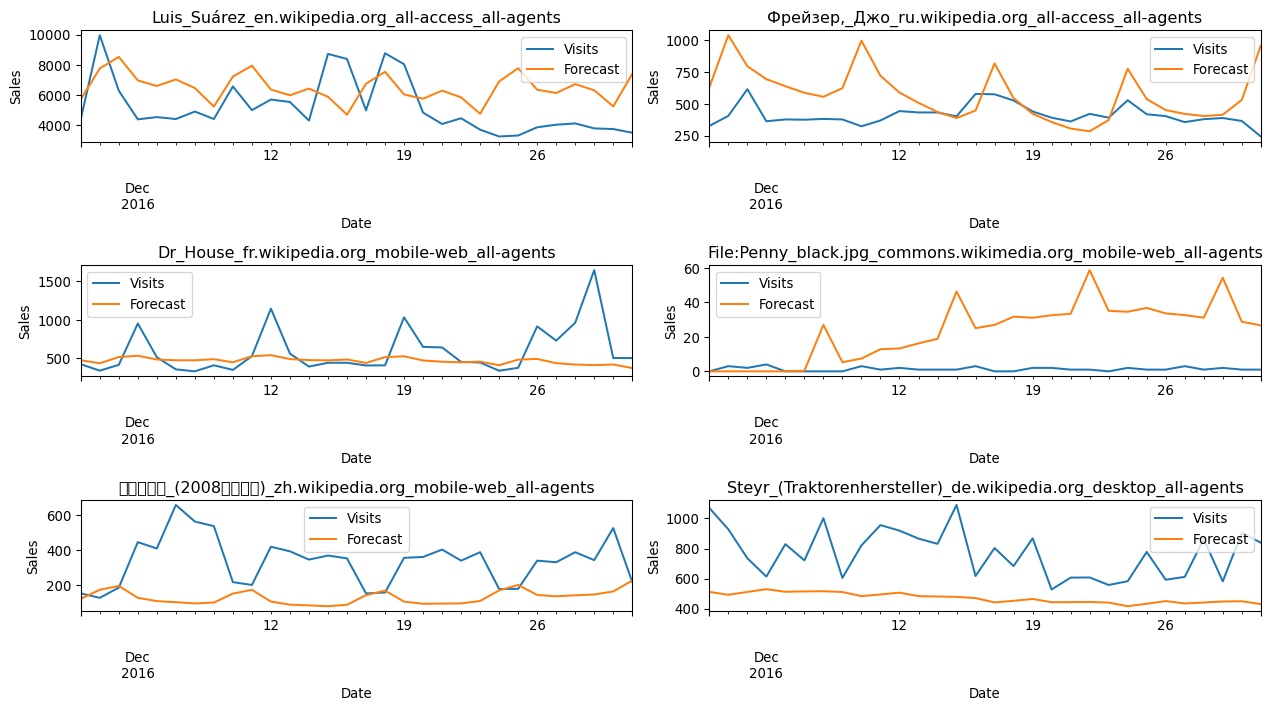

In [232]:
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()
for ax_ ,family in enumerate(p['page'].unique()[:6]):
    p_ = p.loc[p['page'] == family]
    p_.plot(x='ds', y='y', ax=ax[ax_], label='Visits')
    p_.plot(x='ds', y='yhat', ax=ax[ax_], label='Forecast')
    ax[ax_].set_title(family)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sales')
fig.tight_layout()
plt.show()